# Modeling and simulation of wildfires

Modeling the details of actual wildfires is extremely complicated, and obviously very important in helping to protect life and property.  Such detail is beyond the scope of this exercise.  

We're interested here in using the process of wildfire spread to learn about how to build simulation models, and seeing if we can reproduce some basic elements of what is seen in the historical wildfire data, such as a broad distribution of fire sizes and durations. 

Dynamical models typically have three key components:
* state variables describing the configuration of the system at any time
* rules for the time dynamics of the state variables (usually based on their interactions)
* parameters that help to specify the rules

What sorts of ingredients ought to go into a simulation model of wildfires?

## A simple forest fire model (with a long history in the scientific literature)

1. The forest consists of an LxL array of sites.  Each site is either empty (0), filled with a tree (1), or filled with a burning tree (2).
2. The system advances in time steps. At every step, the following updates take place:
    * An empty site will fill with a new tree with probability g.
    * A tree will become a burning tree if any of its 4 neighbors are burning.
    * A burning tree will burn to the ground and the site will become empty.
3. In our version of the model, the forest is surrounded by freeways, also empty of trees.  (In other versions, fires are allowed to "wrap around" left-right and top-bottom).
4. After a fire has completely extinguished itself, a new fire can be initiated by a random lightning strike at one of the filled tree sites.
5. In our version of the model, lightning strikes are rare, so there is only one strike per fire.  (In other versions, any filled tree site is struck by lightning with probability s and is turned into a burning tree.)

Further information: 
* https://en.wikipedia.org/wiki/Forest-fire_model
* http://aryan.app/randomstuff/forestfire.html  (Live online demo of a similar model)

For example, consider a 10x10 forest, where:
* purple = empty (0)
* green = tree (1)
* yellow = burning (2)

An initial configuration such as the one on the left at t=0 would be transformed into the next configurations at t=1 and t=2 (assuming no new trees grew in empty sites).

t = 0 | t = 1 | t = 2
- | - | -
![alt](step0.jpg) | ![alt](step1.jpg) | ![alt](step2.jpg)

What would the next time step look like?

### Getting started

We'll do our work in this notebook, but if you want, you can also start up your Spyder IDE and copy the steps so you have a full working code at the end.

First we want to import the numpy module to get arrays and random numbers, and the matplotlib.pyplot module to do plotting.

Let's also set the tree growth rate to be g=0.0001 .  We are setting g to be small, so we're assuming that new trees don't grow much during an actual fire event.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random

# the next line is for IPython and Jupyter; don't include in Spyder
%matplotlib inline

g = 0.0001

### Assignment #1

Write a function named <code>make_random_forest</code> that takes two inputs (L and p), and returns an LxL numpy array that is filled randomly with 0's and 1's (empty sites and trees), where each site is filled with a tree with probability p.  In addition, set the four boundaries (left, right, top, bottom) to be all empty.

In [62]:
# # My solution
# def make_random_forest(L, p):
# #     forest = np.array()
#     # first generate random array containing 1's with probability p
# #     for i in range(0, L):
# #         for j in range(0, L):
#             forest[j][i] = 1 * (np.random.random((L,L)) < p)
    
    
#     # now set all the boundary elements to be 0
#     return forest

# forest = make_random_forest(10,2)
# plot_forest(forest)


Hint #1: If you were flipping a fair coin, the following code would generate 10 random coin flips, with heads=1 and tails=0 (or vice versa): `1 * (np.random.random(10) < 0.5)`
    
Hint #2: A specific row or column in a 2D array can be sliced out and reset. `a[0,:] = 0` sets the entire first row to be 0;
`a[:,-1] = 0` sets the entire last column to be 0.

### Solution #1

In [67]:
def make_random_forest(L, p):
    # first generate random array containing 1's with probability p
    forest = 1 * (np.random.random((L,L)) < p)
    # now set all the boundary elements to be 0
    forest[ 0,:] = 0
    forest[-1,:] = 0
    forest[:, 0] = 0
    forest[:,-1] = 0
    return forest

### Assignment #2

Enter commands in the preceding cell to test out your <code>make_random_forest</code> function, for a small array (e.g., L=10 and p=0.2).  Print it out.  It should look something like this (with zeros around all 4 boundaries, and ones at random locations):

<code>
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]]
    </code>

### Assignment #3

Write a function named <code>plot_forest</code> that takes one input (a forest array), and makes a plot of the current state.  Test it out with a forest array that you've generated.

Hint #1: Use the <code>plt.pcolor</code> to draw a heatmap of the array based on each site's values.  Set the vmin and vmax arguments to get consistent plotting for different arrays.

Hint #2: If you want to get a square plot (since it's a square forest), you can preinitialize a figure with a square aspect ratio instead of the default rectangular one, e.g., <code>plt.figure(figsize=(6,6))</code>.

In [107]:
# # My solution
# def plot_forest(forest):
#     plt.figure(figsize=(6,6))
    
#     # vmin and vmax are color code
#     plt.pcolor(forest, vmin=0, vmax=2)
    

# forest1 = make_random_forest(10, 0.6)
# plot_forest(forest1)
    

### Solution #3

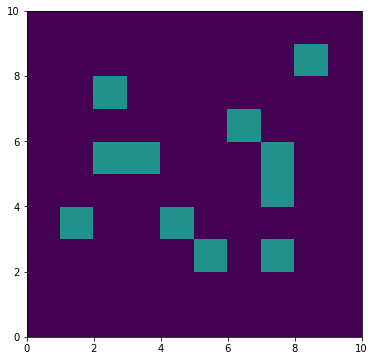

In [64]:
def plot_forest(forest):
    plt.figure(figsize=(6,6))
    plt.pcolor(forest, vmin=0, vmax=2)
    
forest = make_random_forest(10, 0.2)
plot_forest(forest)

### Identifying which sites have burning neighbors

One step of the update algorithm involves identifying those sites in the lattice that (a) are occupied by a tree and (b) have any of their 4 nearest neighbors burning.

A straightforward way to do this would be to loop over all sites in the forest, and at each site investigate whether it has a tree (=1) and has any of its 4 neighbors are burning.  That might look something like this:

In [83]:
def to_burn_next_step_loop(forest):

    burn_next_step = np.zeros_like(forest)   # initialize new array to all zeros

    L = forest.shape[0]
    for i in range(L):
        for j in range(L):
            if forest[i,j] != 1:
                continue       # don't need to look further if there is no tree here
                
            if (forest[i+1,j] == 2) or (forest[i-1,j] == 2) or (forest[i,j+1] == 2) or (forest[i,j-1] == 2):
                burn_next_step[i,j] = 1
    
    return burn_next_step

<b>Question</b>:  In the code above, why don't we have to worry about indices like i+1 and i-1 spilling off the edge of the array?

<b>Answer</b>:  i-1 could spill off the array, but be interpreted as the last row (or last column, for j-1).  On the other hand, i+1 would spill off the end of the array, and would normally generate an indexing error.  <b>But</b>, because we are enforcing there to be no trees (=0) along the array boundaries, for those sites we will never reach line 11 where the neighbor tests are done.

### Investigating the forest using array operations

The loop-over-all-sites approach like the one described above is relatively slow in an interpreted language like Python, since each time a query is done (e.g., forest[i,j]), the code must switch between the interpreted Python layer and the compiled C layer that is used to store NumPy arrays.

Fortunately, NumPy provides fast array-level operations that bundle lots of queries into one call.  (Other languages, such as MATLAB, also provide support for these types of operations.)  We can use some fancy array operations to ask about the status of neighboring sites -- for every site in the lattice -- all at once.  That code looks like this:



In [86]:
def to_burn_next_step_array(forest):

    # identify everywhere the forest is burning
    # if has 2, assign 1. if has 1 assign 0
    b = np.where(forest == 2, 1, 0)
    # count the number of burning neighbors at each site
    nb = np.roll(b, 1, axis=0) + np.roll(b, -1, axis=0) + np.roll(b, 1, axis=1) + np.roll(b, -1, axis=1)
    # return an array with 1 everywhere the forest has a tree and at least 1 neighbor is burning
    return np.where( (forest == 1) * (nb > 0) , 1, 0)

Let's look in more detail at what each of these 3 steps is doing.

![](arrayroll.jpg)

### Timing information

Let's compare how long it takes to compute each of these functions.  The array-based function runs approximately 50-70x faster than the loop-based function.

In [87]:
forest = make_random_forest(200, 0.2)
%timeit to_burn_next_step_loop(forest)
%timeit to_burn_next_step_array(forest)

20.3 ms ± 454 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
299 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [88]:
# Ratio of times
21.1e-3 / 342e-6

61.69590643274854

## Update rules

* An empty site will fill with a new tree with probability g.
* A tree will become a burning tree if any of its 4 neighbors are burning.
* A burning tree will burn to the ground and the site will become empty.

We can implement this by creating a new array (call it <code>updated</code>) that will represent the forest configuration at the next time step.  We want to set the elements of <code>updated</code> based on various criteria:

* If a site is empty AND a random number at that site < g, set the site to 1 (else leave it empty as is).
* If a site has a tree AND has one or more burning neighbors, set the site to 2 (else leave the tree as is).
* If a site is burning, set the site to 0 (empty).

### Assignment #4

1. Assume we are going to create a copy of the forest array named updated: <code>updated = forest.copy()</code>.  This will allow us to reset some of the elements of the <code>updated</code> for the next time step without disturbing the forest array at the current step.

2. Write a function <code>update_empty(forest, updated)</code> that sets the elements of <code>updated</code> to 1 if the site is empty AND a random number < g, otherwise leave it as is.

Hint #1:  The following code will convert all empty sites (<code>forest==0</code>) to tree sites (=1).  

<code>updated = np.where( (forest==0), 1, updated)</code>

Hint #2: You want to modify the above code to convert only <i>some</i> empty sites to trees, with probability g.  You can implement an AND on two conditions by multiplying those condition arrays together, as we did previously in the function <code>to_burn_next_step_array</code>.

### Solution #4

In [89]:
def update_empty(forest, updated):
    updated = np.where( (forest==0) * (np.random.random(forest.shape) < g), 1, updated)
    return updated

### Assignment #5

Now write a similar function for <code>update_trees(forest, updated)</code>.  We've already written the hard part, figuring out which trees will burn next in the function <code>to_burn_next_step_array(forest)</code>.  

Write the function <code>update_trees(forest, updated)</code> to update the tree sites by calling <code>to_burn_next_step_array(forest)</code>.

### Solution #5

In [90]:
def update_trees(forest, updated):
    to_burn = to_burn_next_step_array(forest)
    updated = np.where( to_burn, 2, updated)
    return updated

### Assignment #6

Now finally write a similar function for <code>update_burning(forest, updated)</code>.  This should be pretty straightforward, since the update rule for burning trees is simple.  

### Solution #6

In [108]:
# if it burns, remove it
def update_burning(forest, updated):
    updated = np.where( (forest == 2), 0, updated)
    return updated

### Assignment #7

### Enforcing boundary conditions

We need to make sure that we enforce the no-trees boundary conditions at the 4 external boundaries, since our model states that the forest is enclosed by freeways where trees can't grow.  In our initialization routine, we already set the boundaries to empty, so let's just write a function that does the same thing at every time step.

Write a function <code>enforce_boundary_conditions(updated)</code> that zeros out the 4 boundaries, and returns the newly updated array.

### Solution #7

In [91]:
def enforce_boundary_conditions(updated):
    updated[0,:] = 0
    updated[:,0] = 0
    updated[-1,:] = 0
    updated[:,-1] = 0
    return updated

### Assignment #8

Now we can start putting the pieces together.  Let's write a function named <code>step(forest)</code> that takes the current forest array and returns the updated array at the next time step. The first few parts are already written; you should complete the rest:

In [103]:
# def step(forest):
#     # make a copy of the forest for the next time step
#     updated = forest.copy()

#     # insert code to do empty (0) -> tree (1)
#     updated = update_empty(forest, updated)

#     # insert code to do tree (1) -> burning (2)
    
#     # insert code to do tree (2) -> empty (0)

#     # insert code to enforce boundary conditions

#     return updated

### Solution #8

In [105]:
def step(forest):
    # make a copy of the forest for the next time step
    updated = forest.copy()
    
    # empty (0) -> tree (1)
    updated = update_empty(forest, updated)
    
    # tree (1) -> burning (2)
    updated = update_trees(forest, updated)
    
    # tree (2) -> empty (0)
    updated = update_burning(forest, updated)
    
    # boundary conditions: 0 along boundary
    updated = enforce_boundary_conditions(updated)
    

    return updated

### Assignment #9

Test out your <code>step(forest)</code> function.  First, let's test the burning behavior.

Make a small forest that's mostly empty except for a little fire:
<code>
f = np.zeros((10,10), int)
f[5,5] = 1; f[5,6] = 1; f[6,6] = 2; 
</code>

Now:
* plot the initial forest
* update the forest by one time step, and plot it
* update the forest again by one time step, and plot it

Does the burning behavior look reasonable?

### Solution #9a

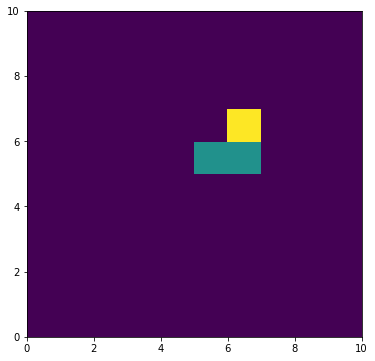

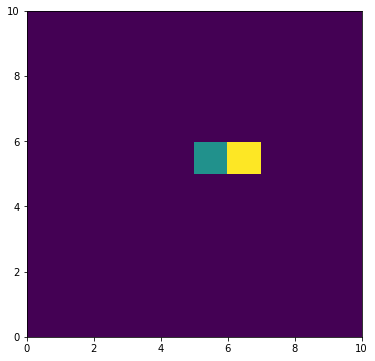

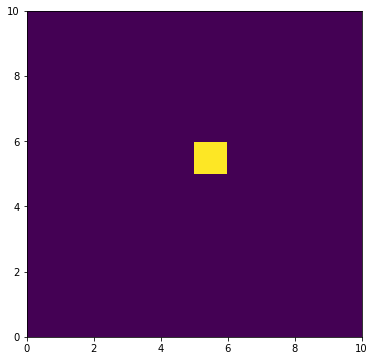

In [109]:
f = np.zeros((10,10), int)
f[5,5] = 1; f[5,6] = 1; f[6,6] = 2; 
plot_forest(f)
f2 = step(f)
plot_forest(f2)
f3 = step(f2)
plot_forest(f3)

### Assignment #9 (continued)

Now, let's test the tree-growing behavior.

Make a bigger forest (200x200) that's completely empty and let it run for 100 time steps:

<code>
f = np.zeros((200,200), int)
for n in range(100):
    f = step(f)
</code>

Some trees should have grown (randomly) during those 100 steps.  How many would you expect should have grown? (Remember: the tree growth rate is g=0.0001)

### Assignment #9 (continued)

There are 200 * 200 sites, 100 time steps for trees to grow, and a growth probability g=0.0001 per site per time step.  Since the growth events are mostly independent (unless a new tree tries to grow where a tree already is), we would expect <code>200 * 200 * 100 * 0.0001 = 400</code> trees to have grown.

How many have actually grown?  How can we compute that?  (Hint: we want to know how many non-zero entries there are in the forest array.)  We wouldn't expect <i>exactly</i> 400 trees to have grown since it's a random process, but it should be close.  How much variance about 400 would we expect?

### Solution #9b

In [110]:
f = np.zeros((200,200), int)
for n in range(100):
    f = step(f)

print(np.count_nonzero(f))

400


### Simulating fire spread

Now that we can implement the update rules, we can simulate fires burning.  This will be done in two parts:

1. We'll write a function named <code>lightning_strike(forest)</code> that randomly selects one site with a tree, and sets in on fire.

2. Then we'll write a function named <code>simulate_one_fire(forest)</code> that takes a forest array, starts a fire with a lightning strike, and updates the dynamics until there are no more trees burning.  

These functions are both a little complicated, so we'll provide them for you given the limitations on time.  But it's good to study them a bit to understand what's going on.

### First: a function to generate a random lightning strike

In [113]:
def lightning_strike(forest):
    """randomly strike sites with lightning until a tree is hit"""
    hits_a_tree = False
    L = forest.shape[0]
    
    while not hits_a_tree:
        random_site_i = np.random.randint(0,L)
        random_site_j = np.random.randint(0,L)
        if forest[random_site_i, random_site_j] == 1:
            # found a tree, update found
            hits_a_tree = True
            
    # now set the site on fire        
    forest[random_site_i, random_site_j] = 2
    return forest

# This is not the most efficient way to start a fire
# Here is some code that will select a random site only among those that have trees
# random_tree_site = tuple([np.random.choice(idx) for idx in np.where(forest==1)])

### Next: a function to step through until all the burning stops

In [119]:
def simulate_one_fire(forest):
    num_trees = np.count_nonzero(forest==1)
    if num_trees == 0:
        print("No trees left to burn")
        return forest, 0, 0
    
    forest = lightning_strike(forest)
    num_burning = np.count_nonzero(forest==2)
    total_burned = num_burning
    duration = 0
    
    # loop till no burning tree left
    while (num_burning > 0):
        forest = step(forest)
        num_burning = np.count_nonzero(forest==2)
        total_burned += num_burning
        duration += 1
    return forest, total_burned, duration

### Assignment #10

Write a function named <code>simulate_many_fires(forest, Nfires)</code> that:
* starts with the forest, and simulates Nfires fires
* calls the <code>simulate_one_fire</code> function written previously
* initializes two empty lists (<code>sizes</code> and <code>durations</code>)
* append the size and duration for each fire to the corresponding list
* on completion, return the forest array in its current state, and the lists of sizes and durations

The initial code looks something like this:

In [123]:
def simulate_many_fires(forest, Nfires):
    # initialize empty sizes and durations lists
    size = []
    duration = []
    
    for n in range(Nfires):
        # burn one fire in the forest
        forest, total_burned, duration = simulate_one_fire(forest)
        
        # append size and duration to the running list
        size.append(total_burned)
        duration.append(duration)
        
        # pass  # call pass just to have some valid code in this loop -- remove once completed
    return forest, sizes, durations

### Solution #10

In [130]:
def simulate_many_fires(forest, Nfires):
    sizes = []
    durations = []
    for n in range(Nfires):
        forest, total_burned, duration = simulate_one_fire(forest)
        sizes.append(total_burned)
        durations.append(duration)
    return forest, sizes, durations

### Investigating the dynamics and statistics of many fires

Let's start with a randomly planted forest, and see how the structure of the forest changes as a result of repeated wildires.  Notice that the trees are pretty much uniformly spread throughout the forest, which makes sense given how we planted them.

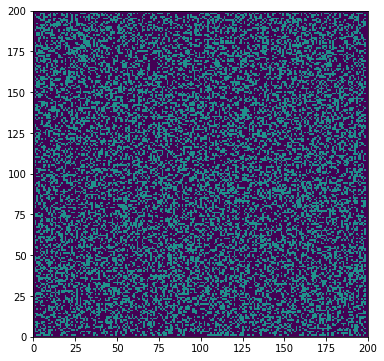

In [131]:
f = make_random_forest(200, 0.4)  # 200 x 200 forest, with approximately 40% trees
# f, size, duration = simulate_one_fire(f)
plot_forest(f)

### Assignment #11

Now let's simulate many fires.

1. Run a simulation of 2000 fires in the forest, collecting statistics on sizes and durations.

2. Plot the forest configuration.

### Solution #11

Note that the forest is now more patchy. There are bigger gaps where there are no trees (presumably because a fire has recently burned there and left it empty), and clustered regions where there are lots of trees (presumably fuel for a future fire).

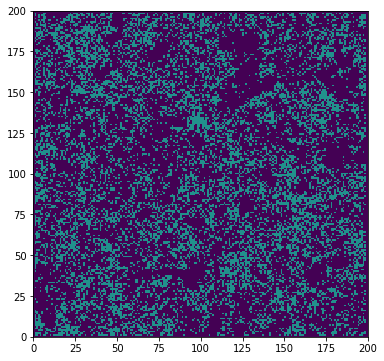

In [132]:
f = make_random_forest(200, 0.4)
f, sizes, durations = simulate_many_fires(f, 2000)
plot_forest(f)

### Plotting individual fires

Before simulating lots of fires to generate statistics, it might be nice to see what the structure of fires looks like in the forest.  There are various ways of doing this.  One simple way is to start with a forest array, simulate several fires, and then to plot the site-by-site difference between the new forest array and the one we started with.  Here's some code that does this, and makes a plot of 200 fires.  The plot is on the following slide.

In [133]:
def simulate_and_plot_many_fires(forest, Nfires):
    plt.figure(figsize=(8,8))
    forest_start = forest.copy()
    for n in range(Nfires):
        forest, total_burned, duration = simulate_one_fire(forest)
        if total_burned == 0:
            break
    diff = forest - forest_start
    plt.pcolor(diff)
    return forest

In this plot, the sites that are green haven't changed at all, the sites that are purple are those that have burned (forming spindly, but connected, clusters), and the sites that are yellow are new trees that have sprung up at random. You should see that the burned fires (purple clusters) are of a variety of sizes.  Consider how this process can lead to the patchy structure observed previously.

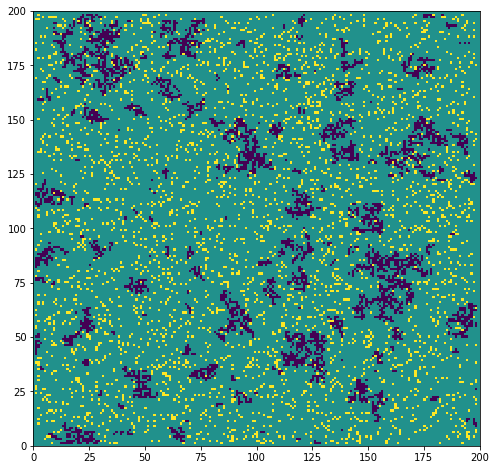

In [134]:
f = simulate_and_plot_many_fires(f, 200)

### Assignment #12

The statistics for the first few thousand fires might not be very reliable, since we were starting from an atypical state (uniform random) and needed to let the patchy pattern develop.  Now that it has developed, let's run for another 2000 fires to collect some new statistics.  After that completes, plot the histograms of the fire sizes and durations.  

Do these distributions look at least qualitatively similar to the distributions we observed in the historical wildfire data?

You might notice that, while there is a heavy tail in the distributions, they tend to fall off faster for large sizes and durations.  This might be due to <i>finite-size effects</i>: because our lattice is only 200x200 sites, there is a limit to how large the fires can be.  If we made a bigger lattice (which would take more time to simulate), we should see this finite-size cutoff move out to larger sizes.

### Solution #12

In [135]:
f, sizes, durations = simulate_many_fires(f, 2000)

Text(0, 0.5, 'P(T)')

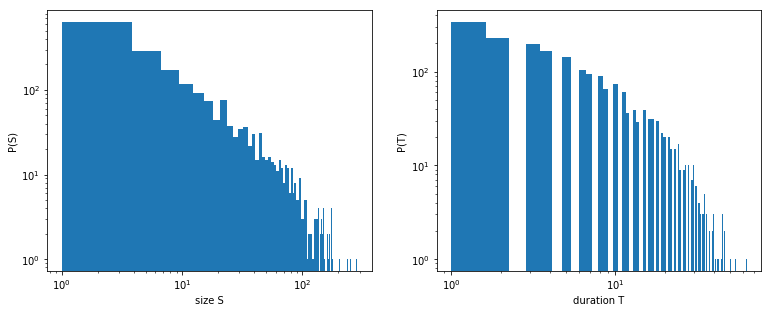

In [136]:
plt.figure(figsize=[12.8,4.8])
plt.subplot(1,2,1)
plt.hist(sizes, bins=100)
plt.loglog()
plt.xlabel('size S'); plt.ylabel('P(S)')
plt.subplot(1,2,2)
plt.hist(durations, bins=100)
plt.loglog()
plt.xlabel('duration T'); plt.ylabel('P(T)')

### Assignment #13

Even though the actual historical wildfire data did not show strong correlations between fire sizes and durations, let's look at the simulation data.

Make a scatterplot of the fire sizes and durations for the simulated fires.

### Solution #13

Text(0, 0.5, 'duration T')

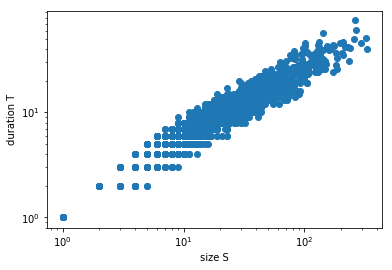

In [28]:
plt.scatter(sizes, durations)
plt.loglog()
plt.xlabel('size S'); plt.ylabel('duration T')

#### We see in the simulation data that sizes and durations are more closely associated, although with a nonlinear (power-law) relationship.  They form roughly a straight line on a log-log plot: what is the slope of the relationship between T and S?

## Revisiting the model

What sorts of things are missing from the model? How might we incorporate them?

* Wind
    * a tree burns only if its upwind neighbor(s) are burning (not just any neighbor)
* Topography
    * growth, spread and lightning parameters that vary spatially over the forest
* Drought
    * increase rate of fire started by lightning strike
    * maybe a burning neighbor doesn't always burn a tree, but does so with probability depending on drought
* Suppression strategies
    * digging firebreaks and lighting controlled burns: what is the optimal placement?
* Climate change
    * parameters for model might change over longer times
 

### Connections to other models

* Infection disease spread: mathematically very similar
    * Tree = Person susceptible to disease
    * Burning Tree = Person infected with disease
    * Tree burns down = Person recovers from disease (or worse)
    * New trees grow = New people are born, susceptible to the infection
    * Infection spreads from infectious to susceptible people through nearby contact or transport through air
    * Control strategies: vaccination, quarantine, etc.
    
![](infection.jpg)

### Multiprocessing

In [137]:
from multiprocessing import Pool

def get_stats(L, p, Nfires, Ntrans):
    f = make_random_forest(L,p)
    f, sizes, durations = simulate_many_fires(f, Ntrans)
    f, sizes, durations = simulate_many_fires(f, Nfires)
    return f, sizes, durations

def get_multi_stats(L, p, Nfires, Ntrans, Nmodels, filename=None):
    pool = Pool()
    n_fillup = [(L, p, Nfires, Ntrans)] * Nmodels
    res = pool.starmap(get_stats, n_fillup)
    pool.close()
    pool.join()
    #
    allsizes = []
    alldurations = []
    for elem in res:
        allsizes.extend(elem[1])
        alldurations.extend(elem[2])
    ST = np.stack((allsizes, alldurations), axis=1)
    if filename is not None:
        np.savetxt(filename, ST)
    return ST

Text(0, 0.5, 'P(T)')

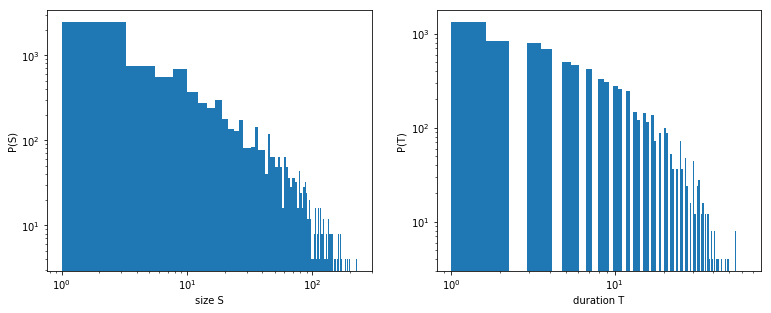

In [138]:
ST = get_multi_stats(200, 0.4, 2000, 1000, 4, 'multi_stats.txt')
plt.figure(figsize=[12.8,4.8])
plt.subplot(1,2,1)
plt.hist(ST[:,0], bins=100)
plt.loglog()
plt.xlabel('size S'); plt.ylabel('P(S)')
plt.subplot(1,2,2)
plt.hist(ST[:,1], bins=100)
plt.loglog()
plt.xlabel('duration T'); plt.ylabel('P(T)')